# Bareinboim Inequalities for MIMIC

In [29]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.stats import rankdata
import matplotlib.pyplot as plt
exportdir='/data/localhost/taufiq/export-dir/'

In [30]:
import logging
logging.basicConfig(filename='hoeff.log', level=logging.INFO)

In [31]:
nra = 5
nr_reps = 1
col_bins_num = 5
use_semisynthetic_obs = False

In [32]:
MIMICtable = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5-filtered.csv')
MIMIC_generated_males = pd.read_csv(exportdir + '/MIMIC-generated-length-5-gender-0.0.csv')
MIMIC_generated_females = pd.read_csv(exportdir + '/MIMIC-generated-length-5-gender-1.0.csv')
MIMICtable = pd.concat([MIMICtable, MIMIC_generated_males, MIMIC_generated_females], ignore_index=True)

In [33]:
if use_semisynthetic_obs:
    observational_data = MIMICtable.copy()
else:
    MIMICtable_combined = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5-combined.csv')
    observational_data = MIMICtable_combined.copy()

In [34]:
len(observational_data)/5

11677.0

In [35]:
age_ranked = rankdata(observational_data['age'])/len(observational_data)
age_bins = np.floor((age_ranked + 0.2499999999)*4)
median_ages = [observational_data.loc[age_bins==1, 'age'].median(), observational_data.loc[age_bins==2, 'age'].median(), observational_data.loc[age_bins==3, 'age'].median(), observational_data.loc[age_bins==4, 'age'].median()]
observational_data = observational_data.rename(columns={"age": "age_raw"})
observational_data['age'] = age_bins


In [36]:
age_ranked = rankdata(MIMICtable['age'])/len(MIMICtable)
age_bins = np.floor((age_ranked + 0.2499999999)*4)
median_ages = [MIMICtable.loc[age_bins==1, 'age'].median(), MIMICtable.loc[age_bins==2, 'age'].median(), MIMICtable.loc[age_bins==3, 'age'].median(), MIMICtable.loc[age_bins==4, 'age'].median()]
MIMICtable = MIMICtable.rename(columns={"age": "age_raw"})
MIMICtable['age'] = age_bins

In [38]:
import os
import glob
os.chdir("/data/localhost/taufiq/pulse-data-5-step")
extension = 'final_.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
all_filenames = all_filenames + [i for i in glob.glob('./synthetic_data/*{}'.format(extension))]
pulse_data = pd.concat([pd.read_csv(f) for f in all_filenames ])
pulse_data = pulse_data.rename(columns={'id': 'icustay_id'})
pulse_data['icustay_id'] = pulse_data['icustay_id'].astype(int)
pulse_data = pulse_data.reset_index(drop=True)
pulse_data = pulse_data.sort_values(by=['icustay_id', 'SimulationTime(s)'], ignore_index=True)
pulse_data['bloc'] = np.arange(len(pulse_data))%5 + 1
pulse_data.head()

,Albumin - BloodConcentration (mg/L),ArterialCarbonDioxidePressure (mmHg),ArterialOxygenPressure (mmHg),ArterialPressure (mmHg),Bicarbonate - BloodConcentration (mg/L),BloodPH (None),BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium - BloodConcentration (mg/L),CarbonDioxideSaturation (None),...,RespirationRate (1/min),SaturationAndFractionOfInspiredOxygenRatio (None),SimulationTime(s),SkinTemperature (degC),Sodium - BloodConcentration (mg/L),SystolicArterialPressure (mmHg),WhiteBloodCellCount (ct/uL),icustay_id,time,bloc
0,36971.911153,40.121759,90.942581,88.417880,1590.189288,7.412477,13.036798,4640.620191,48.207067,0.028632,...,20.134228,4.646044,0.0,33.130515,3327.522356,119.898164,7000.0,3,7.245400e+09,1
1,35899.080416,40.295497,92.240242,92.028320,1590.361120,7.410769,15.109420,4769.504190,54.298146,0.028445,...,20.833333,4.645351,3600.0,32.814843,3316.814960,121.301612,7000.0,3,7.245403e+09,2
2,34887.421594,40.313523,92.215037,106.015304,1590.284502,7.410592,20.730085,4897.953845,60.775848,0.028452,...,20.833333,4.645612,7200.0,32.533793,3307.756345,123.275558,7000.0,3,7.245407e+09,3
3,33927.979505,40.325572,92.262822,103.367986,1590.257833,7.410474,25.855462,5026.549368,66.898886,0.028449,...,20.833333,4.645723,10800.0,32.765652,3302.748443,125.600846,7000.0,3,7.245410e+09,4
4,33088.536551,40.305062,92.327881,71.410965,1589.972682,7.410675,30.823689,5144.112833,72.855658,0.028455,...,20.833333,4.646063,14400.0,32.834440,3277.230920,126.459716,7000.0,3,7.245414e+09,5


In [39]:
len(pulse_data)/5

14610.0

In [40]:
column_mappings = {
    'Albumin - BloodConcentration (mg/L)': 'Albumin',
    'ArterialCarbonDioxidePressure (mmHg)': 'paCO2',
    'ArterialOxygenPressure (mmHg)': 'paO2',
    'Bicarbonate - BloodConcentration (mg/L)': 'HCO3',
    'BloodPH (None)': 'Arterial_pH',
    'Calcium - BloodConcentration (mg/L)': 'Calcium',
    'Chloride - BloodConcentration (mg/L)': 'Chloride',
    'Creatinine - BloodConcentration (mg/L)': 'Creatinine',
    'DiastolicArterialPressure (mmHg)': 'DiaBP',
    'Glucose - BloodConcentration (mg/L)': 'Glucose',
    'Lactate - BloodConcentration (mg/L)': 'Arterial_lactate',
    'MeanArterialPressure (mmHg)': 'MeanBP',
    'Potassium - BloodConcentration (mg/L)': 'Potassium',
    'RespirationRate (1/min)': 'RR',
    'SkinTemperature (degC)': 'Temp_C',
    'Sodium - BloodConcentration (mg/L)': 'Sodium',
    'SystolicArterialPressure (mmHg)': 'SysBP',
    'WhiteBloodCellCount (ct/uL)': 'WBC_count',
    'HeartRate (1/min)': 'HR'
}

pulse_rename = {}

for k, v in column_mappings.items():
    pulse_rename.update({k: f"{v}"})

sim_data = pulse_data.rename(columns=pulse_rename)

sim_data = sim_data.merge(MIMICtable[['gender', 'age', 'Weight_kg', 'icustay_id', 'bloc']], left_on=['icustay_id', 'bloc'], right_on=['icustay_id', 'bloc'])

sim_data.head()

,Albumin,paCO2,paO2,ArterialPressure (mmHg),HCO3,Arterial_pH,BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium,CarbonDioxideSaturation (None),...,Temp_C,Sodium,SysBP,WBC_count,icustay_id,time,bloc,gender,age,Weight_kg
0,36956.148921,38.963593,91.699266,109.970415,1588.920899,7.424054,13.099385,5142.230283,48.184907,0.029009,...,33.112334,3325.983809,115.313637,7000.0,14,4.264269e+09,1,0.0,4.0,73.300003
1,35393.986455,39.348167,92.657544,115.301997,1589.009926,7.420172,15.401907,5358.294397,52.868259,0.028744,...,32.445347,3315.232842,117.565700,7000.0,14,4.264273e+09,2,0.0,4.0,71.800000
2,28799.488674,39.204086,92.999155,55.596113,1588.457784,7.421622,17.884865,6573.488118,48.969245,0.028816,...,32.653264,3306.962520,135.506687,7000.0,14,4.264276e+09,3,0.0,4.0,71.800000
3,28137.774189,39.340030,93.043224,131.119564,1588.152799,7.420254,22.939166,6717.344511,53.651599,0.028764,...,33.029873,3307.121266,138.081243,7000.0,14,4.264280e+09,4,0.0,4.0,71.800000
4,27762.117998,39.349305,93.040334,124.141909,1588.063797,7.420161,27.589372,6797.503106,58.658890,0.028759,...,32.982227,3281.155130,134.524102,7000.0,14,4.264284e+09,5,0.0,4.0,71.800000


In [41]:
import matplotlib.pyplot as plt

column_names_unit = {
    'Albumin': 'Albumin Blood Concentration (mg/L)',
#     'paCO2': 'Arterial $CO_2$ Pressure (mmHg)',
#     'paO2': 'Arterial $O_2$ Pressure (mmHg)',
#     'HCO3': 'Bicarbonate Blood Concentration (mg/L)',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration (mg/L)',
    'Calcium': 'Calcium Blood Concentration (mg/L)',
    'Chloride': 'Chloride Blood Concentration (mg/L)',
    'Creatinine': 'Creatinine Blood Concentration (mg/L)',
    'DiaBP': 'Diastolic Arterial Pressure (mmHg)',
    'SysBP': 'Systolic Arterial Pressure (mmHg)',
    'Glucose': 'Glucose Blood Concentration (mg/L)',
    'MeanBP': 'Mean Arterial Pressure (mmHg)',
    'Potassium': 'Potassium Blood Concentration (mg/L)',
    'RR': 'Respiration Rate (1/min)',
    'Temp_C': 'Skin Temperature (C)',
    'Sodium': 'Sodium Blood Concentration (mg/L)',
    'WBC_count': 'White Blood Cell Count (ct/uL)',
    'HR': 'Heart Rate (1/min)'
}

In [42]:
column_renaming = {
    'Albumin': 'Albumin',
    'paCO2': '$paCO_2$',
    'paO2': '$paO_2$',
    'HCO3': '$HCO_3$',
    'Arterial_pH': 'Arterial_pH',
    'Arterial_lactate': 'Lactate Blood Concentration',
    'Calcium': 'Calcium',
    'Chloride': 'Chloride',
    'Creatinine': 'Creatinine',
    'DiaBP': 'DiaBP',
    'SysBP': 'SysBP',
    'Glucose': 'Glucose',
    'MeanBP': 'MeanBP',
    'Potassium': 'Potassium',
    'RR': 'RR',
    'Temp_C': 'Temp',
    'Sodium': 'Sodium',
    'WBC_count': 'White Blood Cell Count',
    'HR': 'HR'
}

In [43]:
column_names_dict = {
    'Albumin': 'Albumin Blood Concentration',
    'paCO2': 'Arterial $CO_2$ Pressure',
    'paO2': 'Arterial $O_2$ Pressure',
    'HCO3': 'Bicarbonate Blood Concentration',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration',
    'Calcium': 'Calcium Blood Concentration',
    'Chloride': 'Chloride Blood Concentration',
    'Creatinine': 'Creatinine Blood Concentration',
    'DiaBP': 'Diastolic Arterial Pressure',
    'SysBP': 'Systolic Arterial Pressure',
    'Glucose': 'Glucose Blood Concentration',
    'MeanBP': 'Mean Arterial Pressure',
    'Potassium': 'Potassium Blood Concentration',
    'RR': 'Respiration Rate',
    'Temp_C': 'Skin Temperature',
    'Sodium': 'Sodium Blood Concentration',
    'WBC_count': 'White Blood Cell Count',
    'HR': 'Heart Rate'
}

In [44]:
l = [1,2,3,4]
l[:3]

[1, 2, 3]

In [45]:
from statsmodels.stats.multitest import multipletests

# hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/cts_outcome_2bins_yminmax_8020quantiles_split_sim_data_run3/revperc/"
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_2/revperc/"

data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
p_vals = pd.DataFrame()
pruned_hyps = pd.DataFrame()
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval, 'yobs_values': eval, 'ysim_values': eval})
        p_values_pruned = pd.read_csv(f"{hyp_test_dir}/pruned_hyps_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval})
        if len(p_values)>0:
            p_values = p_values.loc[p_values['t']>0]
            p_values['col'] = col
            p_values_pruned['col'] = col
            p_vals = pd.concat([p_vals, p_values], axis=0)
            pruned_hyps = pd.concat([pruned_hyps, p_values_pruned], axis=0)
p_vals['rejected_bonf_lb'] = p_vals['p_lb']<0.05/4/len(p_vals)
p_vals['rejected_bonf_ub'] = p_vals['p_ub']<0.05/4/len(p_vals)
p_vals['rejected_holms_lb'] = multipletests(p_vals['p_lb'], alpha=0.05/4, method='fdr_by')[0]
p_vals['rejected_holms_ub'] = multipletests(p_vals['p_ub'], alpha=0.05/4, method='fdr_by')[0]
p_vals['p_lb_fdr_bh'] = multipletests(p_vals['p_lb'], alpha=0.05/4, method='fdr_bh')[1]
p_vals['p_ub_fdr_bh'] = multipletests(p_vals['p_ub'], alpha=0.05/4, method='fdr_bh')[1]
p_vals['p_lb_fdr_by'] = multipletests(p_vals['p_lb'], alpha=0.05/4, method='fdr_by')[1]
p_vals['p_ub_fdr_by'] = multipletests(p_vals['p_ub'], alpha=0.05/4, method='fdr_by')[1]

for col in tqdm(column_names_dict):
    p_values = p_vals.loc[p_vals['col']==col]
    if len(p_values)>0:
        p_values = p_vals.loc[p_vals['col']==col]
        rej_hyps = p_values[(p_values['rejected_holms_lb']) | (p_values['rejected_holms_ub'])]
        data['columns'].append(col)
        data['total_hypotheses'].append(len(p_values))
        data['rejected_hypotheses'].append(len(rej_hyps))
        data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)


results_bootstrapping_revperc = pd.DataFrame(data)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 979.87it/s]


In [99]:
from statsmodels.stats.multitest import multipletests

hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_2/perc/"

data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
p_vals = pd.DataFrame()
pruned_hyps = pd.DataFrame()
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval, 'yobs_values': eval, 'ysim_values': eval})
        p_values_pruned = pd.read_csv(f"{hyp_test_dir}/pruned_hyps_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval})
        if len(p_values)>0:
            p_values = p_values.loc[p_values['t']>0]
            p_values['col'] = col
            p_values_pruned['col'] = col
            p_vals = pd.concat([p_vals, p_values], axis=0)
            pruned_hyps = pd.concat([pruned_hyps, p_values_pruned], axis=0)
p_vals['rejected_bonf_lb'] = p_vals['p_lb']<0.05/4/len(p_vals)
p_vals['rejected_bonf_ub'] = p_vals['p_ub']<0.05/4/len(p_vals)
p_vals['rejected_holms_lb'] = multipletests(p_vals['p_lb'], alpha=0.05/4, method='fdr_by')[0]
p_vals['rejected_holms_ub'] = multipletests(p_vals['p_ub'], alpha=0.05/4, method='fdr_by')[0]
p_vals['p_lb_fdr_bh'] = multipletests(p_vals['p_lb'], alpha=0.05/4, method='fdr_bh')[1]
p_vals['p_ub_fdr_bh'] = multipletests(p_vals['p_ub'], alpha=0.05/4, method='fdr_bh')[1]
p_vals['p_lb_fdr_by'] = multipletests(p_vals['p_lb'], alpha=0.05/4, method='fdr_by')[1]
p_vals['p_ub_fdr_by'] = multipletests(p_vals['p_ub'], alpha=0.05/4, method='fdr_by')[1]

for col in tqdm(column_names_dict):
    p_values = p_vals.loc[p_vals['col']==col]
    if len(p_values)>0:
        p_values = p_vals.loc[p_vals['col']==col]
        rej_hyps = p_values[(p_values['rejected_holms_lb']) | (p_values['rejected_holms_ub'])]
        data['columns'].append(col)
        data['total_hypotheses'].append(len(p_values))
        data['rejected_hypotheses'].append(len(rej_hyps))
        data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)


results_bootstrapping_perc = pd.DataFrame(data)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 987.71it/s]


In [48]:
col="Chloride"
df = pd.read_csv(f"{hyp_test_dir}/sim_trajecs_actions_held_back_{col}.csv", converters={'x_t': eval, 'actions': eval})
df['actions_tuple'] = df['actions'].apply(tuple)
df['x_tuple'] = df['x_t'].apply(tuple)
# (df['x_tuple']!=(0,0,0,0)).mean()
(df.groupby(by=['actions_tuple']).count()>2)['t'].sum()


In [49]:
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_2/hoeff/"


data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
p_vals = pd.DataFrame()
pruned_hyps = pd.DataFrame()
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffTrue.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffTrue.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval, 'yobs_values': eval, 'ysim_values': eval})
        p_values_pruned = pd.read_csv(f"{hyp_test_dir}/pruned_hyps_{col}_hoeffTrue.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval})
        if len(p_values)>0:
            p_values = p_values.loc[(p_values['t']>0)]
            p_values['col'] = col
            p_values_pruned['col'] = col
            p_vals = pd.concat([p_vals, p_values], axis=0)
            pruned_hyps = pd.concat([pruned_hyps, p_values_pruned], axis=0)
p_vals['rejected_bonf_lb'] = p_vals['p_lb']<0.05/4/len(p_vals)
p_vals['rejected_bonf_ub'] = p_vals['p_ub']<0.05/4/len(p_vals)
p_vals['rejected_holms_lb'] = multipletests(p_vals['p_lb'], alpha=0.05/4, method='fdr_bh')[0]
p_vals['rejected_holms_ub'] = multipletests(p_vals['p_ub'], alpha=0.05/4, method='fdr_bh')[0]
p_vals['p_lb_fdr_bh'] = multipletests(p_vals['p_lb'], alpha=0.05/4, method='fdr_bh')[1]
p_vals['p_ub_fdr_bh'] = multipletests(p_vals['p_ub'], alpha=0.05/4, method='fdr_bh')[1]
p_vals['p_lb_fdr_by'] = multipletests(p_vals['p_lb'], alpha=0.05/4, method='fdr_by')[1]
p_vals['p_ub_fdr_by'] = multipletests(p_vals['p_ub'], alpha=0.05/4, method='fdr_by')[1]
        
for col in tqdm(column_names_dict):
    p_values = p_vals.loc[p_vals['col']==col]
    if len(p_values)>0:
        p_values = p_vals.loc[p_vals['col']==col]
        rej_hyps = p_values[(p_values['rejected_holms_lb']) | (p_values['rejected_holms_ub'])]
        data['columns'].append(col)
        data['total_hypotheses'].append(len(p_values))
        data['rejected_hypotheses'].append(len(rej_hyps))
        data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)

results_hoeff = pd.DataFrame(data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 642.65it/s]


In [50]:
results_hoeff

,columns,total_hypotheses,rejected_hypotheses,percentage_of_rejected_hyp
0,paCO2,35,3,8.571429
1,paO2,39,0,0.000000
2,HCO3,45,2,4.444444
3,Arterial_pH,40,0,0.000000
4,Calcium,44,5,11.363636
5,Chloride,47,24,51.063830
6,DiaBP,36,0,0.000000
7,SysBP,77,2,2.597403
8,Glucose,48,5,10.416667
9,MeanBP,46,0,0.000000


In [51]:
results_bootstrapping_perc

,columns,total_hypotheses,rejected_hypotheses,percentage_of_rejected_hyp
0,paCO2,35,12,34.285714
1,paO2,39,3,7.692308
2,HCO3,45,7,15.555556
3,Arterial_pH,40,0,0.000000
4,Calcium,44,44,100.000000
5,Chloride,47,47,100.000000
6,DiaBP,36,0,0.000000
7,SysBP,77,8,10.389610
8,Glucose,48,19,39.583333
9,MeanBP,46,3,6.521739


In [52]:
results_bootstrapping_revperc

,columns,total_hypotheses,rejected_hypotheses,percentage_of_rejected_hyp
0,paCO2,35,13,37.142857
1,paO2,39,4,10.256410
2,HCO3,45,8,17.777778
3,Arterial_pH,40,0,0.000000
4,Calcium,44,44,100.000000
5,Chloride,47,47,100.000000
6,DiaBP,36,0,0.000000
7,SysBP,77,8,10.389610
8,Glucose,48,19,39.583333
9,MeanBP,46,3,6.521739


In [53]:
results_bootstrapping_revperc #old

,columns,total_hypotheses,rejected_hypotheses,percentage_of_rejected_hyp
0,paCO2,35,13,37.142857
1,paO2,39,4,10.256410
2,HCO3,45,8,17.777778
3,Arterial_pH,40,0,0.000000
4,Calcium,44,44,100.000000
5,Chloride,47,47,100.000000
6,DiaBP,36,0,0.000000
7,SysBP,77,8,10.389610
8,Glucose,48,19,39.583333
9,MeanBP,46,3,6.521739


In [54]:
included_outcomes = ['MeanBP', 'SysBP', 'Glucose', 'Potassium', 'Chloride']

In [55]:
combined_results = results_bootstrapping_revperc[['columns', 'total_hypotheses', 'rejected_hypotheses']].copy()
combined_results.rename(columns={'total_hypotheses': '# Hypotheses', 'rejected_hypotheses': '# Rejections (Bootstrap)'}, inplace=True)
combined_results['# Rejections (Hoeffding)']  = results_hoeff.loc[:, 'rejected_hypotheses']
# combined_results['columns'] = combined_results['Outcomes'].apply(lambda x: column_names_dict[x])
# combined_results = combined_results[combined_results['columns'].isin(included_outcomes)]
combined_results['Outcomes'] = combined_results['columns'].apply(lambda x: column_names_dict[x] + ' ' + f'({column_renaming[x]})')
combined_results.sort_values(by='# Rejections (Hoeffding)', inplace=True)
combined_results['# Hypotheses'] *= 2
print(combined_results[['Outcomes', '# Rejections (Hoeffding)', '# Hypotheses']].to_latex(index=False))
# combined_results


\begin{tabular}{lrr}
\toprule
                                 Outcomes &  \# Rejections (Hoeffding) &  \# Hypotheses \\
\midrule
        Arterial \$O\_2\$ Pressure (\$paO\_2\$) &                         0 &            78 \\
                Arterial pH (Arterial\_pH) &                         0 &            80 \\
      Diastolic Arterial Pressure (DiaBP) &                         0 &            72 \\
          Mean Arterial Pressure (MeanBP) &                         0 &            92 \\
                    Respiration Rate (RR) &                         0 &           172 \\
                          Heart Rate (HR) &                         0 &           162 \\
Bicarbonate Blood Concentration (\$HCO\_3\$) &                         2 &            90 \\
       Systolic Arterial Pressure (SysBP) &                         2 &           154 \\
      Arterial \$CO\_2\$ Pressure (\$paCO\_2\$) &                         3 &            70 \\
    Calcium Blood Concentration (Calcium) &          

/tmp/ipykernel_2456877/334758090.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(combined_results[['Outcomes', '# Rejections (Hoeffding)', '# Hypotheses']].to_latex(index=False))


In [56]:
p_vals[p_vals['col']=='Glucose']

,Unnamed: 0,gender,age,actions,x_t,p_lb,p_ub,Y_lb_mean,Y_ub_mean,Exp_y,...,n_sim_w_pruning,col,rejected_bonf_lb,rejected_bonf_ub,rejected_holms_lb,rejected_holms_ub,p_lb_fdr_bh,p_ub_fdr_bh,p_lb_fdr_by,p_ub_fdr_by
0,0,1.0,4.0,"(3,)","(1.0,)",1.0,3.479019e+00,1277.474219,1670.511719,1422.530469,...,559,Glucose,False,False,False,False,1.0,1.000000e+00,1.0,1.000000e+00
1,1,0.0,4.0,"(3,)","(1.0,)",1.0,1.000000e+00,1274.378442,1734.736965,1429.128002,...,540,Glucose,False,False,False,False,1.0,1.000000e+00,1.0,1.000000e+00
2,2,0.0,1.0,"(3,)","(1.0,)",1.0,4.713792e-01,1193.046816,1578.938288,1352.539997,...,598,Glucose,False,False,False,False,1.0,1.000000e+00,1.0,1.000000e+00
3,3,1.0,1.0,"(4,)","(1.0,)",1.0,1.000000e+00,1042.525060,1662.879408,1354.284869,...,633,Glucose,False,False,False,False,1.0,1.000000e+00,1.0,1.000000e+00
4,4,0.0,3.0,"(7,)","(1.0,)",1.0,3.979876e+00,1132.508075,1562.785330,1350.979555,...,893,Glucose,False,False,False,False,1.0,1.000000e+00,1.0,1.000000e+00
5,5,0.0,3.0,"(3,)","(1.0,)",1.0,9.368259e-10,1251.613696,1444.582740,1350.979555,...,591,Glucose,False,True,False,True,1.0,1.188207e-07,1.0,8.569954e-07
6,6,1.0,3.0,"(3,)","(1.0,)",1.0,3.735215e-08,1253.348187,1521.269637,1376.280463,...,925,Glucose,False,True,False,True,1.0,3.158332e-06,1.0,2.277949e-05
7,7,0.0,2.0,"(3,)","(1.0,)",1.0,5.911451e-06,1215.758507,1541.047171,1356.071723,...,1234,Glucose,False,True,False,True,1.0,2.499230e-04,1.0,1.802571e-03
8,8,1.0,1.0,"(3,)","(1.0,)",1.0,3.217149e-04,1165.397429,1544.502864,1354.284869,...,873,Glucose,False,False,False,True,1.0,7.418941e-03,1.0,5.350915e-02
9,9,1.0,4.0,"(5,)","(1.0,)",1.0,1.000000e+00,1103.783333,1909.370833,1422.530469,...,560,Glucose,False,False,False,False,1.0,1.000000e+00,1.0,1.000000e+00


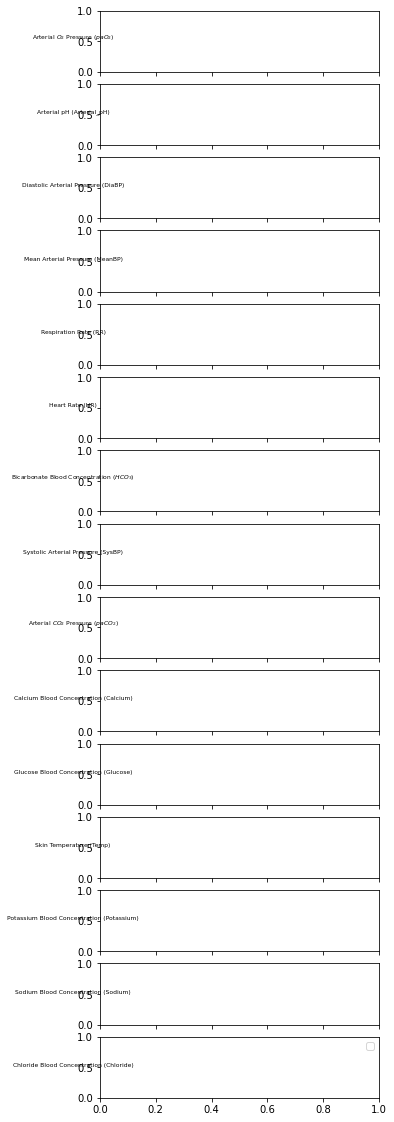

In [57]:
outcomes = combined_results['Outcomes'].unique()
fig, axs = plt.subplots(len(outcomes), 1, figsize=(5,20), sharex=True)
p_vals['Outcomes'] = p_vals['col'].apply(lambda x: column_names_dict[x])
for i in range(len(outcomes)):
    p_values = p_vals[p_vals['Outcomes']==outcomes[i]]
    sns.histplot(x='p_lb', data=p_values, ax=axs[i], bins=25, label='$p_{lb}$')
    sns.histplot(x='p_ub', data=p_values, ax=axs[i], bins=25, label='$p_{ub}$', color='r')
    axs[i].set_xlim([0,1])
    axs[i].set_ylabel(outcomes[i], rotation=0, position=(-10, 0), fontsize=6)
    plt.legend()


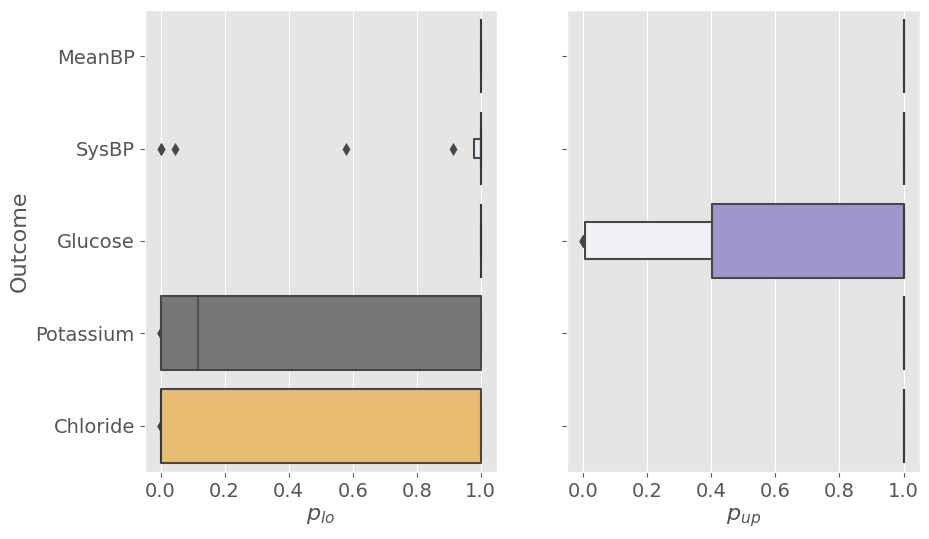

In [59]:
import seaborn as sns

outcomes = combined_results['columns'].unique()
plt.style.use('default')
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)
# p_vals['col'] = p_vals['col'].apply(lambda x: column_names_dict[x])

p_vals_filtered = p_vals.loc[p_vals['col'].isin(included_outcomes)].copy()
p_vals_filtered['Outcomes'] = p_vals_filtered['col'].apply(lambda x: column_renaming[x])
p_vals_filtered['order'] = p_vals_filtered['col'].apply(lambda x: list(outcomes).index(x))
p_vals_filtered['p_lb'] = p_vals_filtered['p_lb'].apply(lambda x: min(x, 1))
p_vals_filtered['p_ub'] = p_vals_filtered['p_ub'].apply(lambda x: min(x, 1))
p_vals_filtered.sort_values(by='order', inplace=True)
ax = sns.boxenplot(x='p_lb', y='Outcomes', data=p_vals_filtered, ax=axs[0] )
ax = sns.boxenplot(x='p_ub', y='Outcomes', data=p_vals_filtered, ax=axs[1] )

# axs[0].set_yticks(fontsize=24)
axs[1].tick_params(axis='x', labelsize=16)
axs[0].set_ylabel('Outcome', fontsize=16)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('$p_{lo}$', fontsize=16)
axs[1].set_xlabel('$p_{up}$', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].tick_params(axis='both', which='minor', labelsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='both', which='minor', labelsize=14)

# plt.savefig("/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_1/images/p_vals.pdf", format='pdf', bbox_inches='tight')



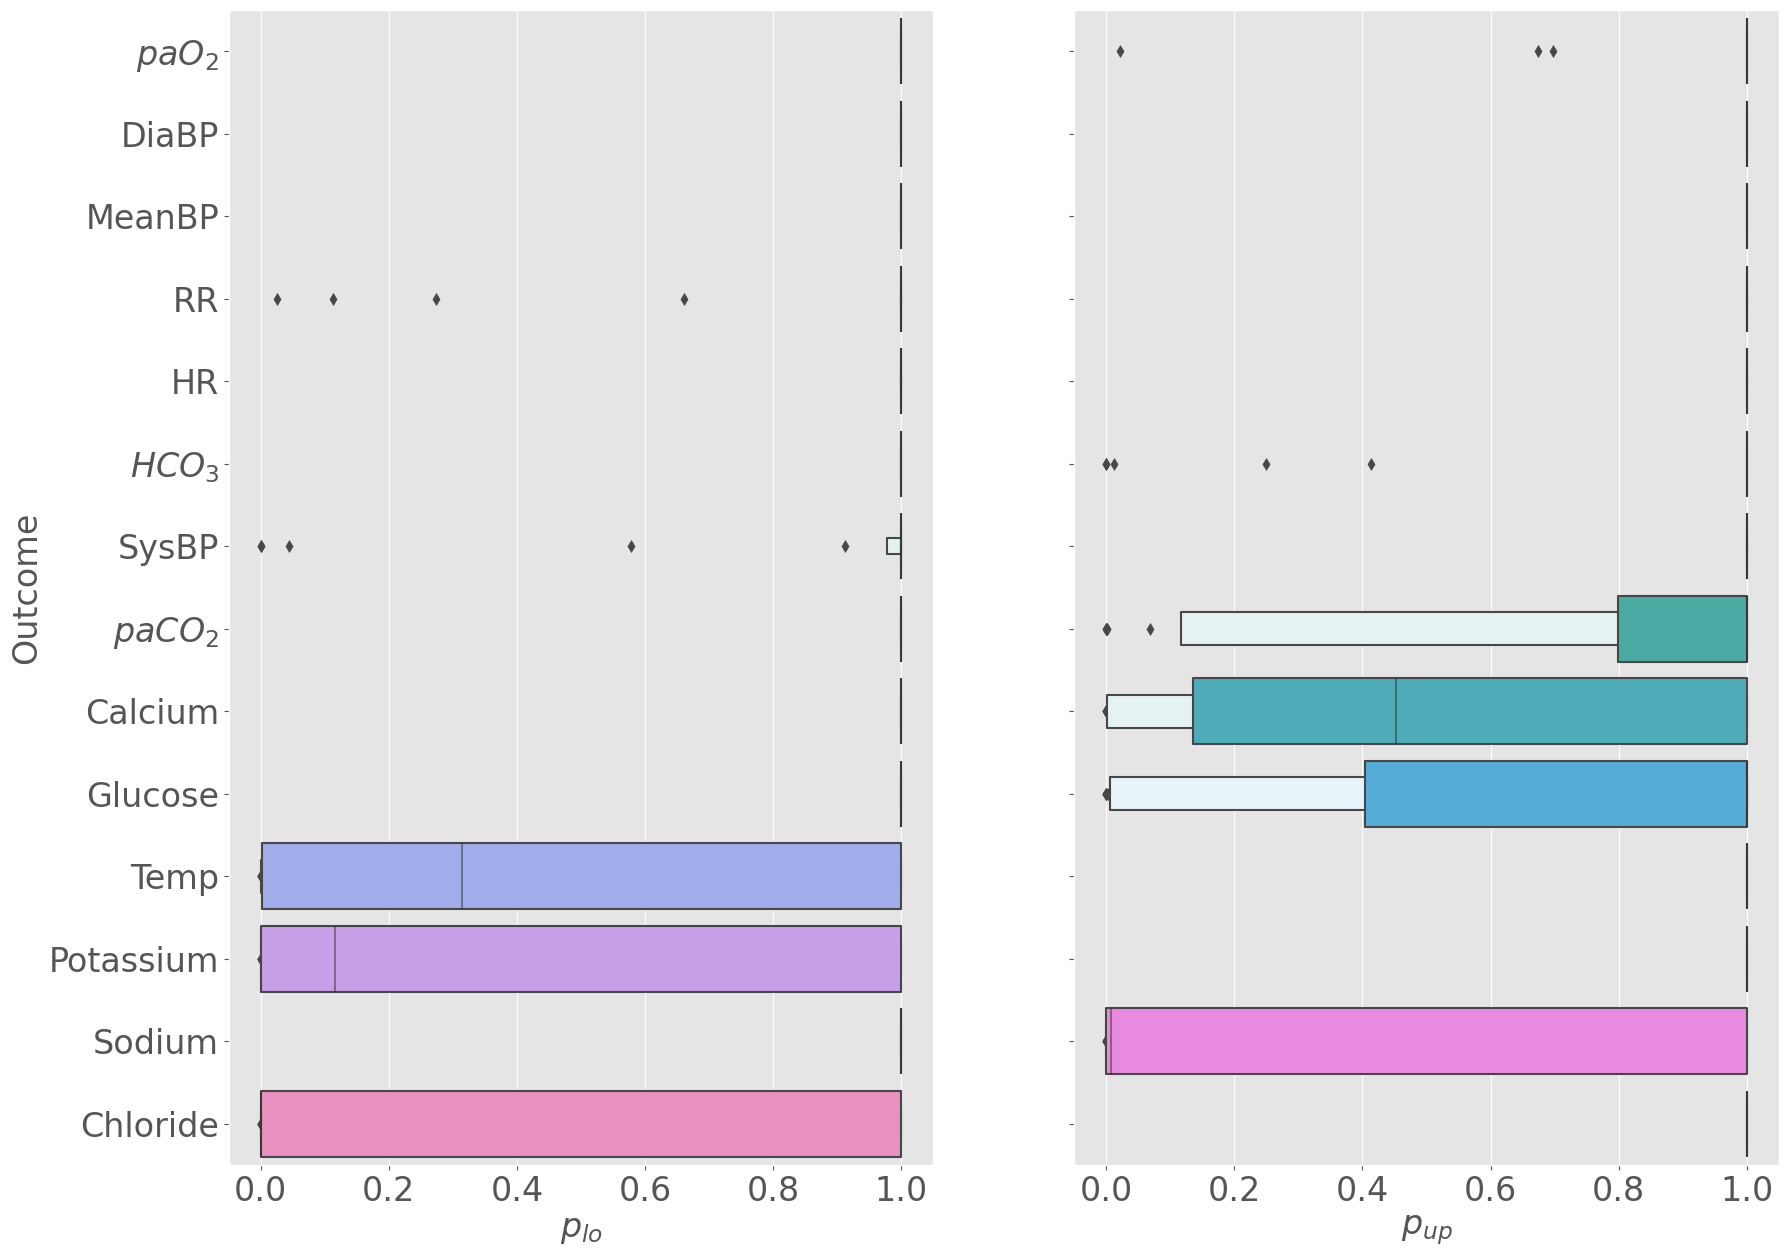

In [60]:
import seaborn as sns

outcomes = combined_results['columns'].unique()
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(20,15), sharey=True)
# p_vals['col'] = p_vals['col'].apply(lambda x: column_names_dict[x])

p_vals = p_vals[p_vals['col']!='Arterial_pH']

p_vals['Outcomes'] = p_vals['col'].apply(lambda x: column_renaming[x])
p_vals['order'] = p_vals['col'].apply(lambda x: list(outcomes).index(x))
p_vals['p_lb'] = p_vals['p_lb'].apply(lambda x: min(x, 1))
p_vals['p_ub'] = p_vals['p_ub'].apply(lambda x: min(x, 1))
p_vals.sort_values(by='order', inplace=True)
ax = sns.boxenplot(x='p_lb', y='Outcomes', data=p_vals, ax=axs[0] )
ax = sns.boxenplot(x='p_ub', y='Outcomes', data=p_vals, ax=axs[1] )

# axs[0].set_yticks(fontsize=24)
axs[1].tick_params(axis='x', labelsize=16)
axs[0].set_ylabel('Outcome', fontsize=24)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('$p_{lo}$', fontsize=24)
axs[1].set_xlabel('$p_{up}$', fontsize=24)
axs[0].tick_params(axis='both', which='major', labelsize=24)
axs[0].tick_params(axis='both', which='minor', labelsize=24)
axs[1].tick_params(axis='both', which='major', labelsize=24)
axs[1].tick_params(axis='both', which='minor', labelsize=24)
# plt.savefig("/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_2/images/p_vals.pdf", format='pdf', bbox_inches='tight')



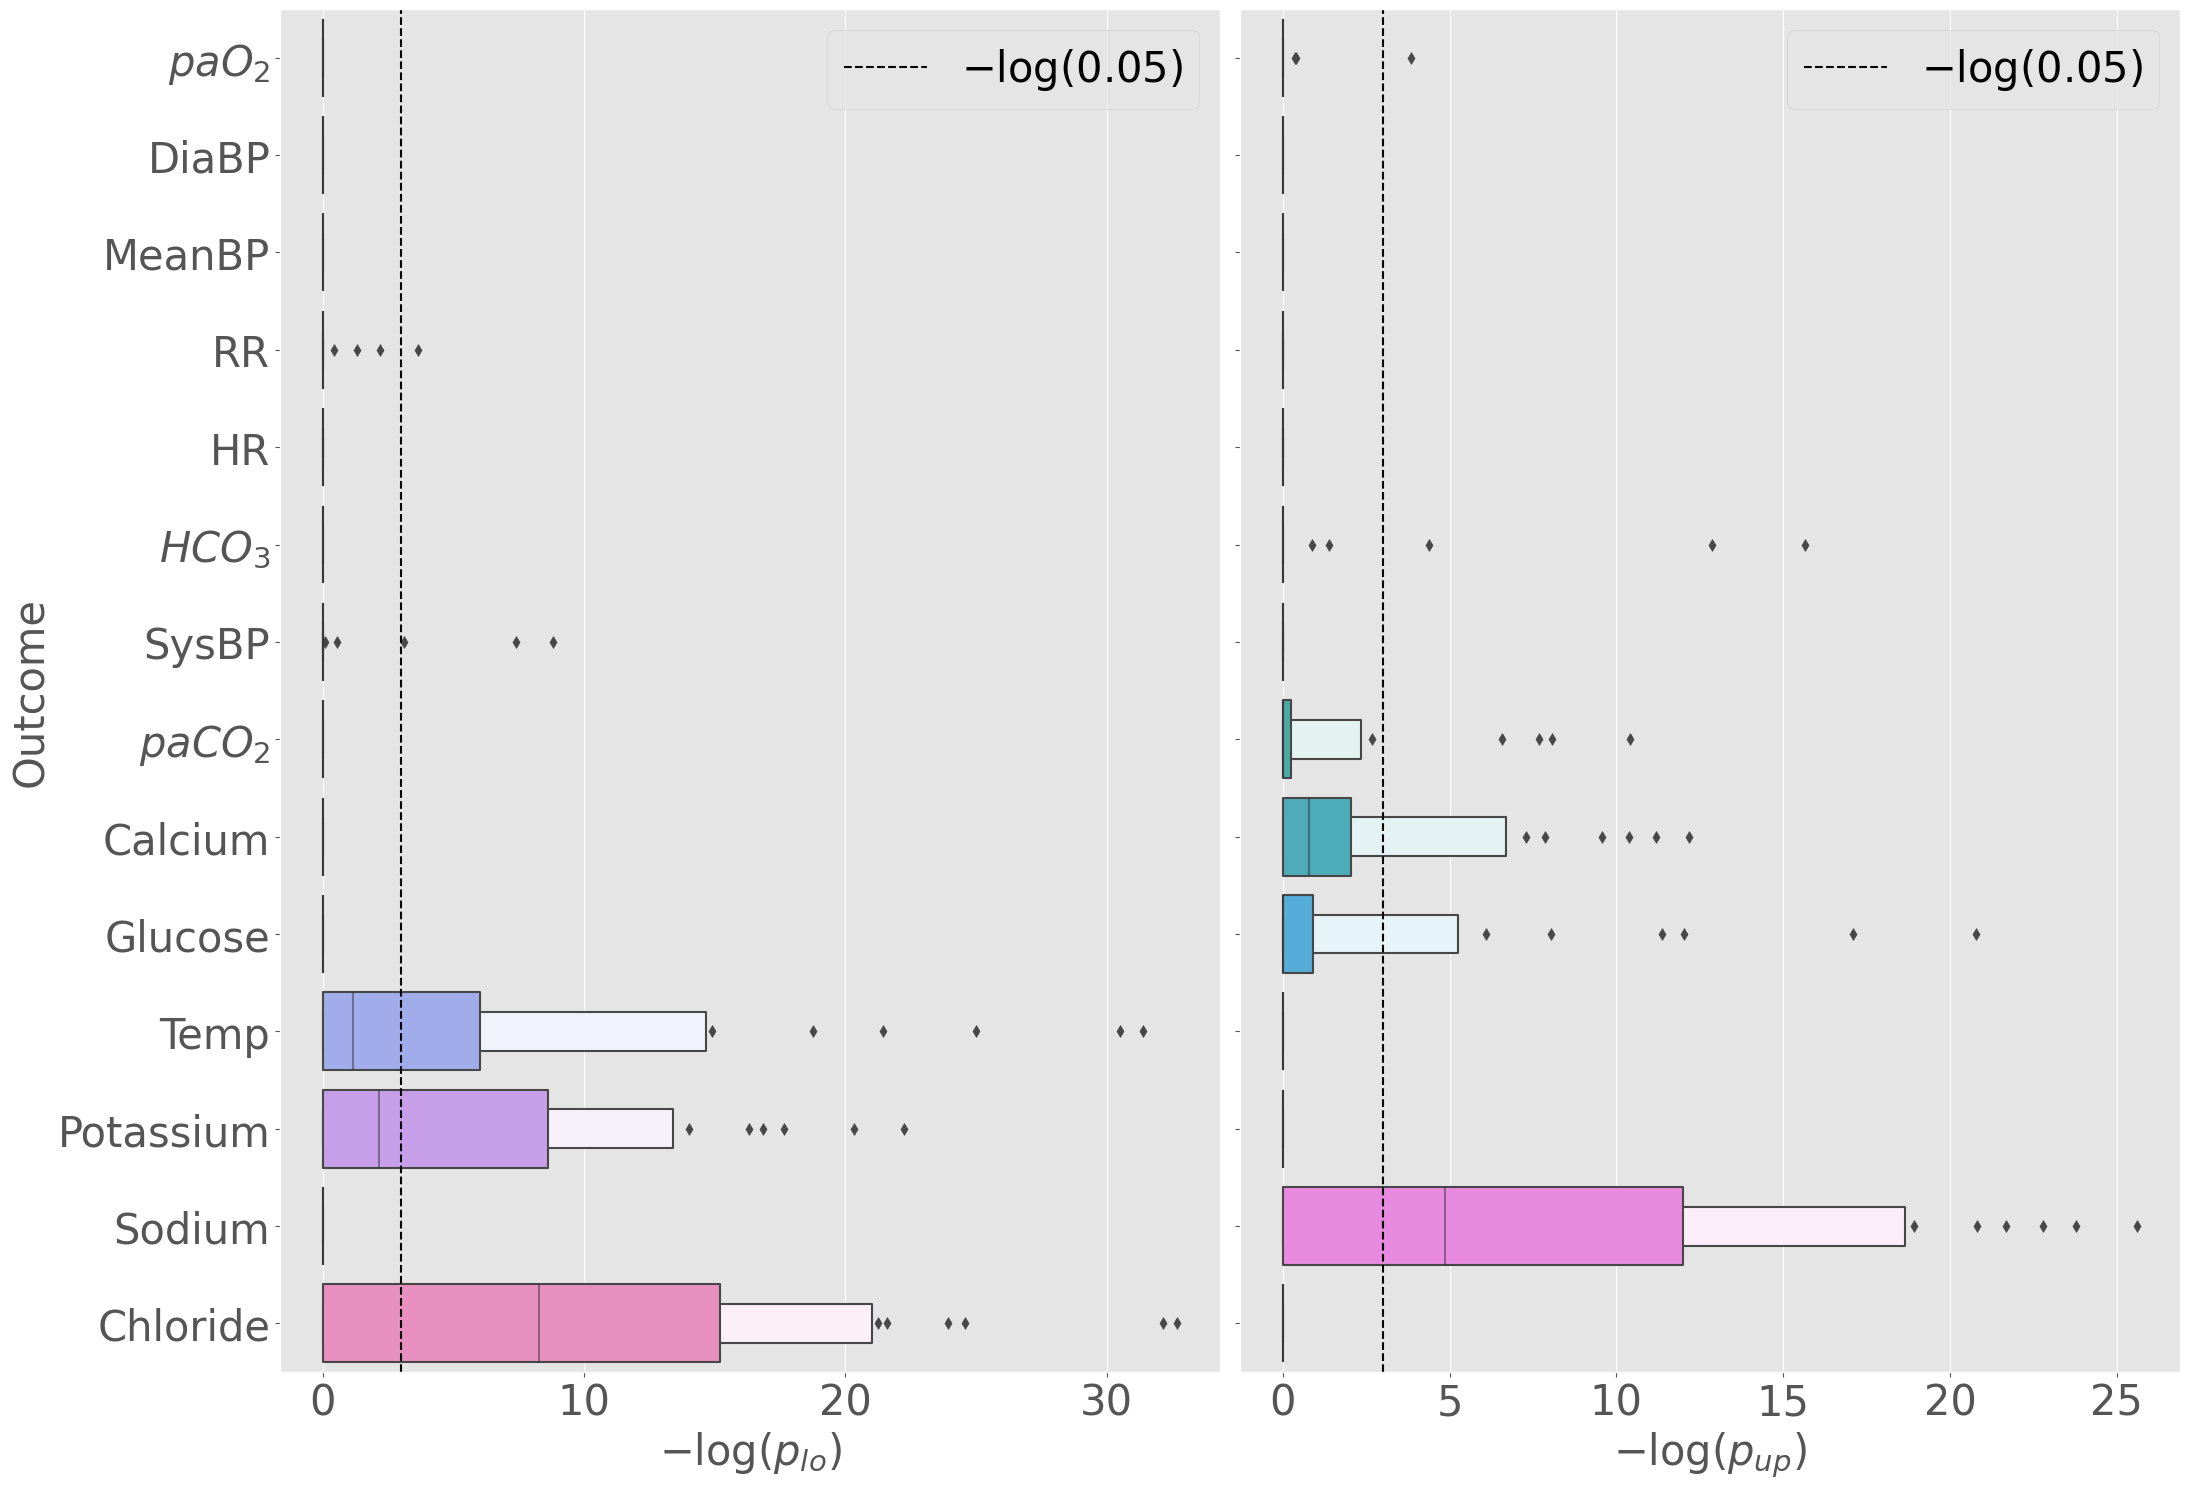

In [95]:
import seaborn as sns

outcomes = combined_results['columns'].unique()
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(22,15), sharey=True)
# p_vals['col'] = p_vals['col'].apply(lambda x: column_names_dict[x])

p_vals = p_vals[p_vals['col']!='Arterial_pH']

p_vals['Outcomes'] = p_vals['col'].apply(lambda x: column_renaming[x])
p_vals['order'] = p_vals['col'].apply(lambda x: list(outcomes).index(x))
p_vals['-log_p_lb'] = p_vals['p_lb'].apply(lambda x: -np.log(min(x, 1)))
p_vals['-log_p_ub'] = p_vals['p_ub'].apply(lambda x: -np.log(min(x, 1)))
p_vals.sort_values(by='order', inplace=True)
ax = sns.boxenplot(x='-log_p_lb', y='Outcomes', data=p_vals, ax=axs[0] )
ax = sns.boxenplot(x='-log_p_ub', y='Outcomes', data=p_vals, ax=axs[1] )
axs[0].axvline(-np.log(0.05), color='k', linestyle='--', label='$-\log(0.05)$',)
axs[1].axvline(-np.log(0.05), color='k', linestyle='--', label='$-\log(0.05)$',)


# axs[0].set_yticks(fontsize=24)
axs[1].tick_params(axis='x', labelsize=30)
axs[0].set_ylabel('Outcome', fontsize=30)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('$-\log(p_{lo})$', fontsize=30)
axs[1].set_xlabel('$-\log(p_{up})$', fontsize=30)
axs[0].tick_params(axis='both', which='major', labelsize=30)
axs[0].tick_params(axis='both', which='minor', labelsize=30)
axs[1].tick_params(axis='both', which='major', labelsize=30)
axs[1].tick_params(axis='both', which='minor', labelsize=30)
axs[0].legend(fontsize=30)
axs[1].legend(fontsize=30)
plt.tight_layout()

# axs[0].set_xticks([-np.log(0.05)])
# axs[0].set_xticklabels(['$-\log(0.05)$'])
# axs[1].set_xticks([-np.log(0.05)])
# axs[1].set_xticklabels(['$-\log(0.05)$'])
plt.savefig("/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_2/images/p_vals3.pdf", format='pdf', bbox_inches='tight')



In [107]:
p_vals[p_vals['col']=='Chloride'].columns

Index(['Unnamed: 0', 'gender', 'age', 'actions', 'x_t', 'p_lb', 'p_ub',
       'Y_lb_mean', 'Y_ub_mean', 'Sim_exp_y', 'Exp_y', 'y_lo', 'y_up',
       'yobs_values', 'ysim_values', 't', 'n_obs', 'n_sim_before_pruning',
       'n_sim', 'col', 'rejected_bonf_lb', 'rejected_bonf_ub',
       'rejected_holms_lb', 'rejected_holms_ub', 'p_lb_fdr_bh', 'p_ub_fdr_bh',
       'p_lb_fdr_by', 'p_ub_fdr_by'],
      dtype='object')

# Heatmaps

In [64]:
def group_by_p_values(x):
    if x < 0.05:
        return '< 0.05'
    if x <= 0.95:
        return '0.05 - 0.95'
    return '> 0.95'

In [96]:
p_vals['p_class_lb'] = p_vals['p_lb'].apply(lambda x: group_by_p_values(x))
p_vals['p_class_ub'] = p_vals['p_ub'].apply(lambda x: group_by_p_values(x))

p_vals[['Outcomes', 'p_class_lb', 'p_lb']].groupby(by=['Outcomes', 'p_class_lb']).count().pivot_table(index="Outcomes", columns="p_class_lb", values="p_lb", aggfunc=np.sum)



p_class_lb,0.05 - 0.95,< 0.05,> 0.95
Outcomes,,,
$HCO_3$,NaN,NaN,45.0
$paCO_2$,NaN,NaN,35.0
$paO_2$,NaN,NaN,39.0
Calcium,NaN,NaN,44.0
Chloride,3.0,30.0,14.0
DiaBP,NaN,NaN,36.0
Glucose,NaN,NaN,48.0
HR,NaN,NaN,81.0
MeanBP,NaN,NaN,46.0


In [ ]:
import HypothesisTesting

import importlib


col="Potassium"
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_1/hoeff/"
p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffTrue.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval, 'yobs_values': eval, 'ysim_values': eval})
p_values['p'] = p_values[['p_lb', 'p_ub']].apply(lambda x: min(x), axis=1)

hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_1/perc/"
p_val_perc = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval, 'yobs_values': eval, 'ysim_values': eval})

p_values = p_values.merge(p_val_perc, on=['gender','age', 'actions', 'x_t'])

MIMIC_data = HypothesisTesting.load_mimic_data("/data/ziz/taufiq/export-dir/", load_generated=False)

ages = []
genders = ['Male', 'Female']
for i in range(1, 4):
    age_min = str(int(MIMIC_data.loc[MIMIC_data['age']==i, 'age_raw'].min()/365))
    age_max = str(int(MIMIC_data.loc[MIMIC_data['age']==i+1, 'age_raw'].min()/365))
    ages.append(f'{age_min}-{age_max}')
ages.append(f'>{age_max}')
p_values['age'] = p_values['age'].apply(lambda x: ages[int(x-1)])
p_values['gender'] = p_values['gender'].apply(lambda x: genders[int(x)])
p_values['Eyobs-Eysim'] = np.absolute(p_values['yobs_values'].apply(lambda x: np.mean(x)) - p_values['ysim_values'].apply(lambda x: np.mean(x)))
pivot = p_values[['gender', 'age', 'p']].groupby(by=['gender', 'age']).mean().pivot_table(index="gender", columns="age", values="p", aggfunc=np.mean)

fig, axs = plt.subplots(1, 2, figsize=(12,3))
labels = np.round(pivot.values,2).astype(str)

sns.heatmap(pivot, vmax=pivot.values.max(), vmin=pivot.values.min(), annot=labels, fmt='', cmap='Blues_r', ax=axs[0], annot_kws={"fontsize":20}, cbar=False)

pivot = p_values[['gender', 'age', 'Eyobs-Eysim']].groupby(by=['gender', 'age']).mean().pivot_table(index="gender", columns="age", values="Eyobs-Eysim", aggfunc=np.mean)
labels = np.round(pivot.values,2).astype(str)

sns.heatmap(pivot, vmax=pivot.values.max(), vmin=pivot.values.min(), annot=labels, fmt='', cmap='Blues', ax=axs[1], annot_kws={"fontsize":20}, cbar=False)

axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].tick_params(axis='both', which='minor', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='minor', labelsize=16)

axs[0].set_xlabel('Age', fontsize=16)
axs[1].set_xlabel('Age', fontsize=16)
axs[0].set_ylabel('', fontsize=16)
axs[1].set_ylabel('', fontsize=16)

axs[0].set_title("Average $p$-values", fontsize=16)
axs[1].set_title("$\mathbb{E}[|Y^{obs} - Y^{sim} | \mid X_0 \in (gender, age) ]$", fontsize=16)

plt.tight_layout()


In [ ]:
p_values

# Save histogram plots

In [ ]:
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/cts_outcome_2bins_yminmax_8020quantiles_d0_splitting_t5/perc"

data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
p_vals = pd.DataFrame()
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval, 'yobs_values': eval, 'ysim_values': eval})
        p_values['col'] = col
        p_values['Exp_y'] = p_values['Exp_y'].apply(lambda val: eval(val) if 'nan' not in val else [])
        p_vals = pd.concat([p_vals, p_values], axis=0)
        rej_hyps = p_values[(p_values['p_ub'] < 0.05/4) | (p_values['p_lb'] < 0.05/4)]
        data['columns'].append(col)
        data['total_hypotheses'].append(len(p_values))
        data['rejected_hypotheses'].append(len(rej_hyps))
        data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)

results_bootstrapping = pd.DataFrame(data)


In [ ]:
p_vals

In [ ]:
def get_hoeffding_bounds(index, row, alpha=0.05):
    ylo, yup = row['y_lo'], row['y_up']
    nobs, nsim = row['n_obs'], row['n_sim']
    delta_obs = (yup - ylo)*np.sqrt(1/(2*nobs)*np.log(4/alpha))
    delta_sim = (yup - ylo)*np.sqrt(1/(2*nsim)*np.log(4/alpha))
    ylb_lb = np.mean(row['Y_lb_mean']) - delta_obs
    ylb_ub = np.mean(row['Y_lb_mean']) + delta_obs
    yub_lb = np.mean(row['Y_ub_mean']) - delta_obs
    yub_ub = np.mean(row['Y_ub_mean']) + delta_obs
    ysim_lb = np.mean(np.clip(row['ysim_values'], ylo, yup)) - delta_sim
    ysim_ub = np.mean(np.clip(row['ysim_values'], ylo, yup)) + delta_sim
    return [ylb_lb , ylb_ub], [ysim_lb, ysim_ub], [yub_lb, yub_ub]

In [ ]:
import matplotlib as mpl

def add_interval(ax, xdata, ydata, color, left, caps="  ",):
    line = ax.add_line(mpl.lines.Line2D(xdata, ydata, color=color, linewidth=4, alpha=0.4),)
    anno_args1 = {
        'ha': 'left',
        'va': 'center',
        'size': 16,
        'color': color
    }
    anno_args2 = {
        'ha': 'right',
        'va': 'center',
        'size': 16,
        'color': color
    }
    if left:
        a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0]), alpha=0.4, **anno_args2)
    else:
        a1 = ax.annotate(caps[1], xy=(xdata[1], ydata[1]), alpha=0.4, **anno_args1)

In [ ]:
def generate_histograms_bootstrapping(index, row, results_directory, total_hypotheses):
    fig, axs = plt.subplots(1, 2, figsize=(18,8))
    plt.style.use('ggplot')
    a = axs[1].hist(row['Y_lb_mean'], label='$Q_{lo}$', density=False, alpha=0.4, bins='auto', color='blue')
    a = axs[1].hist(row['Y_ub_mean'], label='$Q_{up}$', density=False, alpha=0.4, bins='auto', color=sns.color_palette("mako", 10)[5])
    a = axs[1].hist(row['Sim_exp_y'], label='$Q^{twin}$', density=False, alpha=0.4, bins='auto', color='red')
#     a = axs[1].hist(row['Sim_exp_y'], label='$Q^{twin}$', density=True, alpha=0.4, bins='auto', color='red')

    axs[0].hist(row['yobs_values'], label='$Y$ values', density=True, alpha=0.4, bins='auto', color='blue')
    axs[0].hist(row['ysim_values'], label='$Y^{twin}$ values', density=True, alpha=0.4, bins='auto', color='red')
    # axs[0].axvline(row['y_lo'], linestyle='--', color='black', label='$y_{lo}$ & $y_{up}$')
    # axs[0].axvline(x=row['y_up'], linestyle='--', color='black')
    p_lb, p_ub = row['p_lb'], row['p_ub']
    # plt.suptitle(f'p_lb = {p_lb} | p_ub = {p_ub} | n_sim = {row["n_sim"]} | n_obs = {row["n_obs"]}', fontsize=14)
    rejected = (row['rejected_holms_lb']) or (row['rejected_holms_ub'])
    figtitle = f"{row['col']}_hyp_{index}"
    
    ylb_interval, ysim_interval, yub_interval = get_hoeffding_bounds(index, row, alpha=0.05/total_hypotheses)
    ylb_interval = np.clip(ylb_interval, row['y_lo'], row['y_up'])
    ysim_interval = np.clip(ysim_interval, row['y_lo'], row['y_up'])
    yub_interval = np.clip(yub_interval, row['y_lo'], row['y_up'])
    max_ylim = axs[1].get_ylim()[1]
    axs[1].fill_betweenx([0, max_ylim], ylb_interval[0], ylb_interval[1], color='purple', alpha=0.1, label='Hoeffding CIs')
    axs[1].fill_betweenx([0,max_ylim], ysim_interval[0], ysim_interval[1], color='purple', alpha=0.1,)
    axs[1].fill_betweenx([0,max_ylim], yub_interval[0], yub_interval[1], color='purple', alpha=0.1,)
    axs[1].axvline(row['y_lo'], linestyle='--', color='black', label='$y_{lo}$ & $y_{up}$')
    axs[1].axvline(x=row['y_up'], linestyle='--', color='black')
    axs[0].set_xlabel(column_names_unit[row['col']], fontsize=20)
    axs[1].set_xlabel(column_names_unit[row['col']], fontsize=20)
    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[0].grid(False)
    axs[1].grid(False)

    min_ylim = axs[1].get_ylim()[0]
    max_ylim = axs[1].get_ylim()[1]
    min_xlim = axs[1].get_xlim()[0]
    max_xlim = axs[1].get_xlim()[1]
    axs[1].axhline(min_ylim, color='black')
    axs[1].axvline(min_xlim, color='black')
    axs[1].axhline(max_ylim, color='black')
    axs[1].axvline(max_xlim, color='black')
    
    
    min_ylim = axs[0].get_ylim()[0]
    max_ylim = axs[0].get_ylim()[1]
    min_xlim = axs[0].get_xlim()[0]
    max_xlim = axs[0].get_xlim()[1]
    axs[0].axhline(min_ylim, color='black')
    axs[0].axvline(min_xlim, color='black')
    axs[0].axhline(max_ylim, color='black')
    axs[0].axvline(max_xlim, color='black')

    axs[1].legend(fontsize=20, )
    axs[0].legend(fontsize=20, )    
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].tick_params(axis='both', which='minor', labelsize=20)
    axs[1].tick_params(axis='both', which='major', labelsize=20)
    axs[1].tick_params(axis='both', which='minor', labelsize=20)
    plt.tight_layout()

#     plt.savefig(f"{results_directory}/histograms/{row['col']}_rej{rejected}/{figtitle}_with_hoeff")    
#     plt.close()


In [ ]:
def generate_hoeff_intervals_same_plt(index, row, results_directory, total_hypotheses):
    fig, axs = plt.subplots(1, 1, figsize=(8,8))
    plt.style.use('ggplot')

    axs.hist(row['yobs_values'], label='$Y$ values', density=True, alpha=0.4, bins='auto', color='blue')
    axs.hist(row['ysim_values'], label='$\hat{Y}$ values', density=True, alpha=0.4, bins='auto', color='red')
    p_lb, p_ub = row['p_lb'], row['p_ub']
    rejected = (row['rejected_holms_lb']) or (row['rejected_holms_ub'])
    figtitle = f"{row['col']}_hyp_{index}"
    
    ylb_interval, ysim_interval, yub_interval = get_hoeffding_bounds(index, row, alpha=0.05/total_hypotheses)
    ylb_interval = np.clip(ylb_interval, row['y_lo'], row['y_up'],)
    ysim_interval = np.clip(ysim_interval, row['y_lo'], row['y_up'], )
    yub_interval = np.clip(yub_interval, row['y_lo'], row['y_up'], )
    
    
    axs[1].plot(ylb_interval, [0.5,0.5], lw=6, color='blue', label='$Q_{lo}$', alpha=0)
    axs[1].plot(yub_interval, [0.5,0.5], lw=6, color='red', label='$Q_{up}$', alpha=0)
    axs[1].plot(ysim_interval, [0.5,0.5], lw=6, color=sns.color_palette("mako", 10)[5], label='$\hat{Q}$',alpha=0)

#     axs[0].set_xlabel(column_names_unit[row['col']], fontsize=20)
    axs.set_xlabel(column_names_unit[row['col']], fontsize=20)
    axs.set_yticks([])
    axs.grid(False)


    min_ylim = axs.get_ylim()[0]
    max_ylim = axs.get_ylim()[1]
    min_xlim = axs.get_xlim()[0]
    max_xlim = axs.get_xlim()[1]
    axs.axhline(min_ylim, color='black')
    axs.axvline(min_xlim, color='black')
    axs.set_xlim([min_xlim, max_xlim])
    
#     axs.plot(ylb_interval, [max_ylim, max_ylim], lw=6, color='blue', label='$Q_{lo}$', alpha=0.3)
#     axs.plot(yub_interval, [max_ylim, max_ylim], lw=6, color='red', label='$Q_{up}$', alpha=0.3)
#     axs.plot(ysim_interval, [max_ylim, max_ylim], lw=6, color=sns.color_palette("mako", 10)[5], label='$\hat{Q}$',alpha=0.3)

    add_interval(axs, ylb_interval, [max_ylim, max_ylim], color='blue', caps="()", )
    add_interval(axs, yub_interval, [max_ylim*1.05, max_ylim*1.05], caps="()", color='red')
    add_interval(axs, ysim_interval, [max_ylim*1.1, max_ylim*1.1], caps="()", color=sns.color_palette("mako", 10)[5],)

    axs.legend(fontsize=16, )    
    axs.tick_params(axis='both', which='major', labelsize=20)
    axs.tick_params(axis='both', which='minor', labelsize=20)
    plt.tight_layout()

#     plt.savefig(f"{results_directory}/histograms/{row['col']}_rej{rejected}/{figtitle}_with_hoeff")    
#     plt.close()


In [ ]:
def generate_hoeff_intervals(index, row, results_directory, total_hypotheses, lo=True):
    fig, axs = plt.subplots(2, 1, figsize=(6,7), gridspec_kw={'height_ratios': [6, 1]})
    plt.style.use('ggplot')

    axs[0].hist(row['yobs_values'], label='$Y(A_{1:t})$', density=True, alpha=0.4, bins='auto', color='blue')
    axs[0].hist(row['ysim_values'], label='$\widehat{Y}(a_{1:t})$', density=True, alpha=0.4, bins='auto', color='red')
    p_lb, p_ub = row['p_lb'], row['p_ub']
    rejected = (row['rejected_holms_lb']) or (row['rejected_holms_ub'])
    figtitle = f"{row['col']}_hyp_{index}"
    
    ylb_interval, ysim_interval, yub_interval = get_hoeffding_bounds(index, row, alpha=0.05/total_hypotheses)
    ylb_interval = np.clip(ylb_interval, row['y_lo'], row['y_up'],)
    ysim_interval = np.clip(ysim_interval, row['y_lo'], row['y_up'], )
    yub_interval = np.clip(yub_interval, row['y_lo'], row['y_up'], )
    
    if lo:
        add_interval(axs[1], [ylb_interval[0], row['y_up']], [0,0], caps="||", color="blue", left=True)
        add_interval(axs[1], [row['y_lo'] , ysim_interval[1]], [0.5,0.5], caps="||", color="red", left=False)
        axs[1].set_yticks([0, 0.5], ['$Q_{lo}$', '$\widehat{Q}$'])
        axs[1].plot([ylb_interval[0], row['y_up']], [0,0], lw=6, color='blue', alpha=0.)
        axs[1].plot([row['y_lo'] , ysim_interval[1]], [0.5,0.5], lw=6, color='red',  alpha=0.)
    else:
        add_interval(axs[1], [ysim_interval[0], row['y_up']], [0.5,0.5], caps="||", color="red", left=True)
        add_interval(axs[1], [row['y_lo'], ylb_interval[1]], [0,0], caps="||", color="blue", left=False)
        axs[1].plot([ysim_interval[0], row['y_up']], [0.5,0.5], lw=6, color='blue', alpha=0.)
        axs[1].plot([row['y_lo'], ylb_interval[1]], [0.,0.], lw=6, color='red',  alpha=0.)
        axs[1].set_yticks([0, 0.5], ['$Q_{up}$', '$\widehat{Q}$'])
        
    
    axs[0].set_xlabel(column_names_unit[row['col']], fontsize=20)
    axs[0].set_yticks([])
    axs[0].grid(False)
    axs[1].grid(False)


    min_ylim = axs[1].get_ylim()[0]
    max_ylim = axs[1].get_ylim()[1]
    axs[1].set_ylim([-0.2, 0.7])

    axs[0].legend(fontsize=16, ) 

    axs[1].set_xlabel('Hoeffdings Intervals', fontsize=20)
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].tick_params(axis='both', which='minor', labelsize=20)
    axs[1].tick_params(axis='both', which='major', labelsize=20)
    axs[1].tick_params(axis='both', which='minor', labelsize=20)
    
    plt.tight_layout()

#     plt.savefig(f"{results_directory}/histograms/{row['col']}_rej{rejected}/{figtitle}_with_hoeff")    
#     plt.close()


In [ ]:
column = "Potassium"
index = 7
row = p_vals.loc[p_vals['col']==column].iloc[index]
image_export_dir="/data/ziz/not-backed-up/taufiq/HypothesisTesting/cts_outcome_2bins_yminmax_8020quantiles_split_sim_data_run3/images"

generate_hoeff_intervals(index, row, image_export_dir, total_hypotheses=len(p_vals), lo=False)


In [ ]:
import seaborn as sns

def generate_longitudinal_plots(row, p_values, results_directory):
    a = row['actions']
    age = row['age']
    gender = row['gender']
    x_t = row['x_t']
    
    y_lb = []
    y_ub = []
    y_twin = []
    y_twin_lb = []
    y_twin_ub = []
    y_obs = []
    y_obs_lb = []
    y_obs_ub = []
    y_obs_std = []
    
    for t in range(1, 5):
        p_values_filtered = p_values[(p_values['gender'] == gender) & (p_values['age'] == age) & (p_values['actions'] == a[:t]) & (p_values['x_t'] == x_t[:t])  & (p_values['t'] == t)]
        y_lb.append(np.quantile(p_values_filtered['Y_lb_mean'].values[0], 0.05/4))
        y_ub.append(np.quantile(p_values_filtered['Y_ub_mean'].values[0], 1 - 0.05/4))
        y_twin.append(np.mean(p_values_filtered['Sim_exp_y'].values[0]))
        y_twin_lb.append(np.quantile(p_values_filtered['Sim_exp_y'].values[0], 0.05/4))
        y_twin_ub.append(np.quantile(p_values_filtered['Sim_exp_y'].values[0], 1 - 0.05/4))
        y_obs.append(np.mean(p_values_filtered['yobs_values'].values[0]))
        y_obs_std.append(np.std(p_values_filtered['yobs_values'].values[0])/len(p_values_filtered['yobs_values'].values[0]))
        y_obs_lb.append(np.quantile(p_values_filtered['Exp_y'].values[0], 0.05/4))
        y_obs_ub.append(np.quantile(p_values_filtered['Exp_y'].values[0], 1 - 0.05/4))
    
    x = [1, 2, 3, 4]
    fig, axis = plt.subplots(1, 1, figsize=(18,8))
#     axis.plot(x, y_obs, color = sns.color_palette("mako", 10)[2], label="Obs data mean")
    axis.plot(x, y_obs, color = 'purple', label="Obs data mean")
#     axis.fill_between(x, np.array(y_obs) - 2*np.array(y_obs_std), np.array(y_obs) + 2*np.array(y_obs_std), label="Obs data uncertainty", color=sns.color_palette("mako", 10)[6], alpha = 0.4)
#     axis.fill_between(x, y_obs_lb, y_obs_ub, label="Obs data uncertainty", color=sns.color_palette("mako", 10)[6], alpha = 0.4)
    axis.fill_between(x, y_obs_lb, y_obs_ub, label="Obs data uncertainty", color='purple', alpha = 0.2)
    axis.plot(x, y_twin, color = sns.color_palette("mako", 10)[5], label="Sim data mean")
    axis.fill_between(x, y_twin_lb, y_twin_ub, label="Sim data uncertainty", color=sns.color_palette("mako", 10)[5], alpha = 0.2)
    axis.fill_between(x, y_lb, y_ub, color='r', alpha=0.1, label='$[\hat{Q}_{lo}, \hat{Q}_{up}]$ interval')
    axis.set_xlabel('Time (hr)', fontsize=13)
    axis.set_ylabel(column_names_unit[col], fontsize=13)
    p_lb, p_ub = row['p_lb'], row['p_ub']
    plt.suptitle(f'$n_{{sim}}$ = {row["n_sim"]} | $n_{{obs}}$ = {row["n_obs"]}', fontsize=16)

    plt.legend()
    plt.style.use('fivethirtyeight')


In [ ]:
p_values_complete_trajecs = p_values[(p_values['t']==4)].copy()

# p_values_complete_trajecs['ysim_values'] = p_values_complete_trajecs['ysim_values'].apply(lambda x: eval(x))
# p_values_complete_trajecs['yobs_values'] = p_values_complete_trajecs['yobs_values'].apply(lambda x: eval(x))
p_values_complete_trajecs['Exp_y'] = p_values_complete_trajecs['Exp_y'].apply(lambda x: eval(x))

# p_values['yobs_values'] = p_values['yobs_values'].apply(lambda x: eval(x))

In [ ]:

for index, row in tqdm(p_values_complete_trajecs.iterrows()):
    if index == 229:
        continue
    generate_histograms_bootstrapping(index, row, hyp_test_dir)
    
#     generate_longitudinal_plots(row, p_values, hyp_test_dir)
    break

In [ ]:
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/rerun/boot_rev_perc/"
col="Calcium"

p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv", converters={'actions': eval, 'x_t': eval})
p_values = p_values.loc[p_values['t']>0]

p_values['p_lb'].hist()

In [ ]:
p_vals_filtered = p_vals[(p_vals['col'] == 'HR') & (p_vals['t'] == 1)]

p_vals_filtered
len(p_vals_filtered)




In [ ]:
zx = plt.hist(p_vals['n_obs'], label='n_obs', density=True, alpha=0.3, bins='auto')
plt.legend()

In [ ]:
ax = plt.hist(p_vals_filtered['n_sim'], label='n_sim', density=True, alpha=0.3, bins='auto')
plt.legend()

In [ ]:
ax = plt.hist(p_vals_filtered['n_obs_with_actions_of_interest'], label='n_obs_with_actions_of_interest', density=True, alpha=0.3, bins='auto')
plt.legend()


In [ ]:
ax = plt.hist(p_vals_filtered['n_obs'], label='n_obs', density=True, alpha=0.3, bins='auto')
plt.legend()

In [ ]:
ax = plt.hist(p_vals_filtered['n_obs_with_actions_of_interest'], label='n_obs_with_actions_of_interest', density=True, alpha=0.3, bins='auto')
plt.legend()


In [ ]:
ax = plt.hist(p_vals_filtered['n_sim'], label='n_sim', density=True, alpha=0.3, bins='auto')
plt.legend()

In [ ]:
ax = plt.hist(p_vals_filtered['n_sim_w_pruning'], label='n_sim_w_pruning', density=True, alpha=0.3, bins='auto')
plt.legend()

In [ ]:
col_name = 'Temp_C'
p_vals['interval len'] = p_vals['Y_ub_mean'] - p_vals['Y_lb_mean']
p_vals1['interval len'] = p_vals1['Y_ub_mean'] - p_vals1['Y_lb_mean']


plt.hist(p_vals.loc[p_vals['col']==col_name, 'interval len'], label='after', density=True, alpha=0.3, bins=100)
plt.hist(p_vals1.loc[p_vals1['col']==col_name, 'interval len'], label='before', density=True, alpha=0.3, bins=60)
plt.legend()
# plt.xlim([0,10])

In [ ]:
col_name = 'HR'
p_vals['interval len'] = p_vals['Y_ub_mean'] - p_vals['Y_lb_mean']

plt.hist(p_vals.loc[p_vals['col']=='HR', 'interval len'])